In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from pathlib import Path
import cv2
import time
import random
from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from keras import utils
from torchvision import datasets, transforms
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("All Libraries Imported Successfully")

c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All Libraries Imported Successfully


In [2]:
data_dir = "Bone Break Classification"

In [3]:
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.


In [4]:
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 112 files for validation.


In [5]:
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [6]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())
    
    #append labels to y_train
    y_train.append(labels.numpy())
    

x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [8]:
x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())
    
    #append labels to y_train
    y_val.append(labels.numpy())
    

x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [9]:
def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [10]:
class_names_dict = {
    0: 'Avulsion fracture', 
    1: 'Comminuted fracture', 
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [11]:
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [12]:
y_train.shape,y_val.shape

((1017, 10), (112, 10))

In [13]:
input_layer = layers.Input(shape=(256,256, 3))

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(input_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    64,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    128,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    256,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model1 = models.Model(input_layer, output_layer)

In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                             

In [15]:
opt = optimizers.Adam(learning_rate=0.0005)
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [16]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",  
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [17]:
history = model1.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

Epoch 1/10
32/32 [==============================] - 27s 770ms/step - loss: 2.6634 - accuracy: 0.1691 - val_loss: 2.3400 - val_accuracy: 0.1786
Epoch 2/10
32/32 [==============================] - 25s 794ms/step - loss: 1.9888 - accuracy: 0.3038 - val_loss: 1.9937 - val_accuracy: 0.3036
Epoch 3/10
32/32 [==============================] - 25s 766ms/step - loss: 1.5523 - accuracy: 0.4769 - val_loss: 1.0962 - val_accuracy: 0.6696
Epoch 4/10
32/32 [==============================] - 24s 749ms/step - loss: 1.0371 - accuracy: 0.6932 - val_loss: 0.7853 - val_accuracy: 0.7589
Epoch 5/10
32/32 [==============================] - 22s 698ms/step - loss: 0.6409 - accuracy: 0.8378 - val_loss: 0.4436 - val_accuracy: 0.9196
Epoch 6/10
32/32 [==============================] - 22s 698ms/step - loss: 0.4099 - accuracy: 0.9194 - val_loss: 0.4081 - val_accuracy: 0.8839
Epoch 7/10
32/32 [==============================] - 23s 707ms/step - loss: 0.2384 - accuracy: 0.9735 - val_loss: 0.2488 - val_accuracy: 0.9375

In [19]:
train_loss, train_accuracy = model1.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model1.evaluate(x_val, y_val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 99.61%
Test Accuracy: 95.54%


In [20]:
CLASSES = np.array(class_names)

preds = model1.predict(x_val)

4/4 [==============================] - 1s 108ms/step


In [21]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [22]:
def display_preds_act(n=10, figsize=(15,3)):
    
    indices = np.random.choice(range(len(y_val)), n)
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

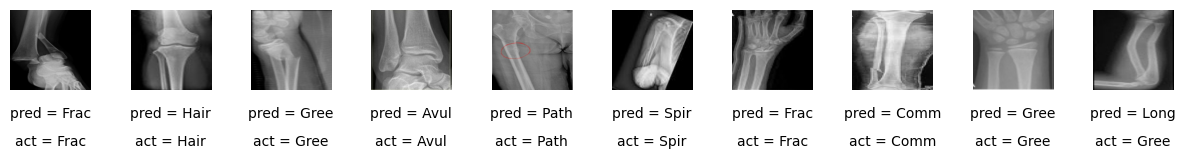

In [23]:
display_preds_act(n=10)

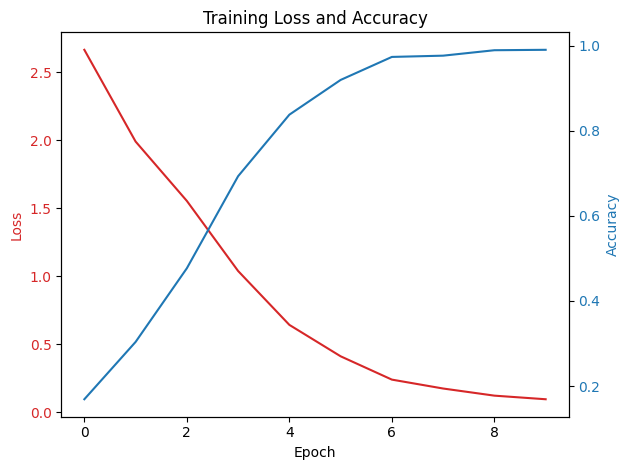

In [24]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Training Loss and Accuracy')
fig.tight_layout()
plt.show()

In [25]:
y_pred = model1.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

class_names = [
    'Avulsion fracture', 
    'Comminuted fracture', 
    'Fracture Dislocation',
    'Greenstick fracture',
    'Hairline Fracture',
    'Impacted fracture',
    'Longitudinal fracture',
    'Oblique fracture',
    'Pathological fracture',
    'Spiral Fracture'
]

report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

4/4 [==============================] - 0s 99ms/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.92      1.00      0.96        11
  Comminuted fracture       0.93      0.93      0.93        15
 Fracture Dislocation       1.00      1.00      1.00        17
  Greenstick fracture       1.00      0.90      0.95        10
    Hairline Fracture       0.91      1.00      0.95        10
    Impacted fracture       0.88      0.88      0.88         8
Longitudinal fracture       0.92      0.92      0.92        12
     Oblique fracture       1.00      1.00      1.00        10
Pathological fracture       1.00      0.92      0.96        12
      Spiral Fracture       1.00      1.00      1.00         7

             accuracy                           0.96       112
            macro avg       0.96      0.95      0.95       112
         weighted avg       0.96      0.96      0.96       112



In [26]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate per-class metrics
precision1 = precision_score(y_true_classes, y_pred_classes, average=None)
recall1 = recall_score(y_true_classes, y_pred_classes, average=None)
f11 = f1_score(y_true_classes, y_pred_classes, average=None)
mcc1 = matthews_corrcoef(y_true_classes, y_pred_classes)
kappa = cohen_kappa_score(y_true_classes, y_pred_classes)

# For specificity, we need to compute it manually
specificity1 = []
for i in range(conf_matrix.shape[0]):
    # True Negatives: sum all elements except the ith row and ith column
    tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    # False Positives: sum the ith column except the diagonal
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    # False Negatives: sum the ith row except the diagonal
    fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]
    # True Positives: diagonal element
    tp = conf_matrix[i, i]
    specificity1.append(tn / (tn + fp))
print(f"Precision per class: {precision1}")
print(f"Recall per class: {recall1}")
print(f"F1 Score per class: {f11}")
print(f"Specificity per class: {specificity1}")
print(f"Cohen's Kappa Score: {kappa}")
print(f"Matthews Correlation Coefficient (MCC): {mcc1}")

Precision per class: [0.91666667 0.93333333 1.         1.         0.90909091 0.875
 0.91666667 1.         1.         1.        ]
Recall per class: [1.         0.93333333 1.         0.9        1.         0.875
 0.91666667 1.         0.91666667 1.        ]
F1 Score per class: [0.95652174 0.93333333 1.         0.94736842 0.95238095 0.875
 0.91666667 1.         0.95652174 1.        ]
Specificity per class: [0.9900990099009901, 0.9896907216494846, 1.0, 1.0, 0.9901960784313726, 0.9903846153846154, 0.99, 1.0, 1.0, 1.0]
Cohen's Kappa Score: 0.9500401463110001
Matthews Correlation Coefficient (MCC): 0.9502096941548658


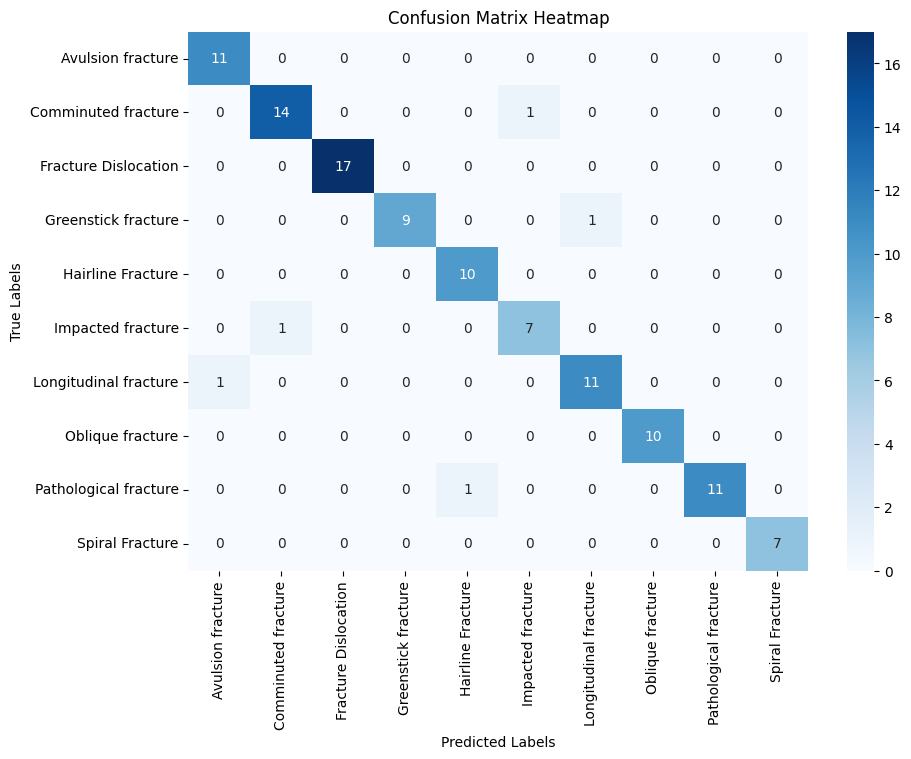

In [27]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names_dict.values()),
            yticklabels=list(class_names_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [28]:
model1.save("BONE NET V1.h5")

In [30]:
import pickle
with open('./models/BONE NET V1.pkl', 'wb') as f:
    pickle.dump(model1, f)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\dropout_3
......vars
...layers\dropout_4
......vars
...layers\flatten
......vars
...layers\inp